# Feature Selection

In [25]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --quiet rioxarray
    !pip3 install xarray
    !pip3 install rasterio
    !pip3 install fiona
    !pip install matplotlib-scalebar
    !pip install XlsxWriter
    !pip3 install rioxarray
    !pip install plotnine pdpbox

In [26]:
import os
import fiona
import geopandas as gpd
import importlib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, LeaveOneGroupOut, cross_validate, cross_val_predict, GridSearchCV
from sklearn.feature_selection import RFECV, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from numpy import sqrt, mean, absolute

# http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_dir =  '/content/drive/MyDrive/Thesis/Clean Thesis code/'

import sys
sys.path.append(os.path.join(base_dir, 'scripts'))

import modeling
from modeling import Metrics

import Config
importlib.reload(Config)

from Config import (
    df_corr_columns_to_drop, df_corr_Geo_columns, seasonal_variables,
    columns_to_drop, feature_groups_list, rf_predictor_list, svr_predictor_list,
    gbr_predictor_list,rename_preds_dict)

importlib.reload(modeling)

Database_gpkg = os.path.join(base_dir, 'Database.gpkg')
Model_data = os.path.join(base_dir, 'Model_data.gpkg')
print(f"Model_data: {fiona.listlayers(Model_data)}")
print(f"Database_gpkg: {fiona.listlayers(Database_gpkg)}")

In [ ]:
def remove_negative(df):
    """
    Remove negative values from the DataFrame.
    """
    numeric_cols = df.select_dtypes(include='number').columns
    df[numeric_cols] = df[numeric_cols].clip(lower=0)

    return df

#Load data
train_data = gpd.read_file(Model_data, layer='train_data', driver='GPKG')
test_data = gpd.read_file(Model_data, layer='test_data', driver='GPKG')
Final_data= gpd.read_file(Model_data, layer='Final_data', driver='GPKG')

datasets = [train_data, test_data, Final_data]
dfp = []
for dataset in datasets:
  df=dataset.copy()
  df = dataset.drop(columns_to_drop, axis=1).rename(columns= {'Rn_Poten':'GRP'})
  df = remove_negative(df)
  dfp.append(df)

train_sample, test_sample, Final_sample = dfp[0], dfp[1], dfp[2]
_Final_sample=Final_sample.copy()
#print(Final_data.shape)
#print(Final_sample.shape)

In [62]:
# helper functions

def scaled_data(unscaled_df):
    """
    Scale the data excluding specified columns.
    """
    data_to_scale = unscaled_df.copy()
    feature_to_exclude = 'grids_36k'
    features_to_scale = [col for col in data_to_scale.columns if col != feature_to_exclude]
    scaler = StandardScaler()
    data_to_scale[features_to_scale] = scaler.fit_transform(data_to_scale[features_to_scale])

    return data_to_scale

def drop_all_seasonal_values(scaled_data):
    """
    Drop columns identified as seasonal variables from the DataFrame.
    """
    #seasonal_variable = seasonal_variables.rename(columns=rename_preds_dict)
    scaled_multiannual = scaled_data.drop(seasonal_variables, axis=1)

    return scaled_multiannual

Final_sample = scaled_data(Final_sample).rename(columns=rename_preds_dict)
Final_sample_nonseasonal = drop_all_seasonal_values(scaled_data(_Final_sample)).rename(columns=rename_preds_dict)
X = Final_sample.iloc[:,1:]
y = _Final_sample["GRP"]

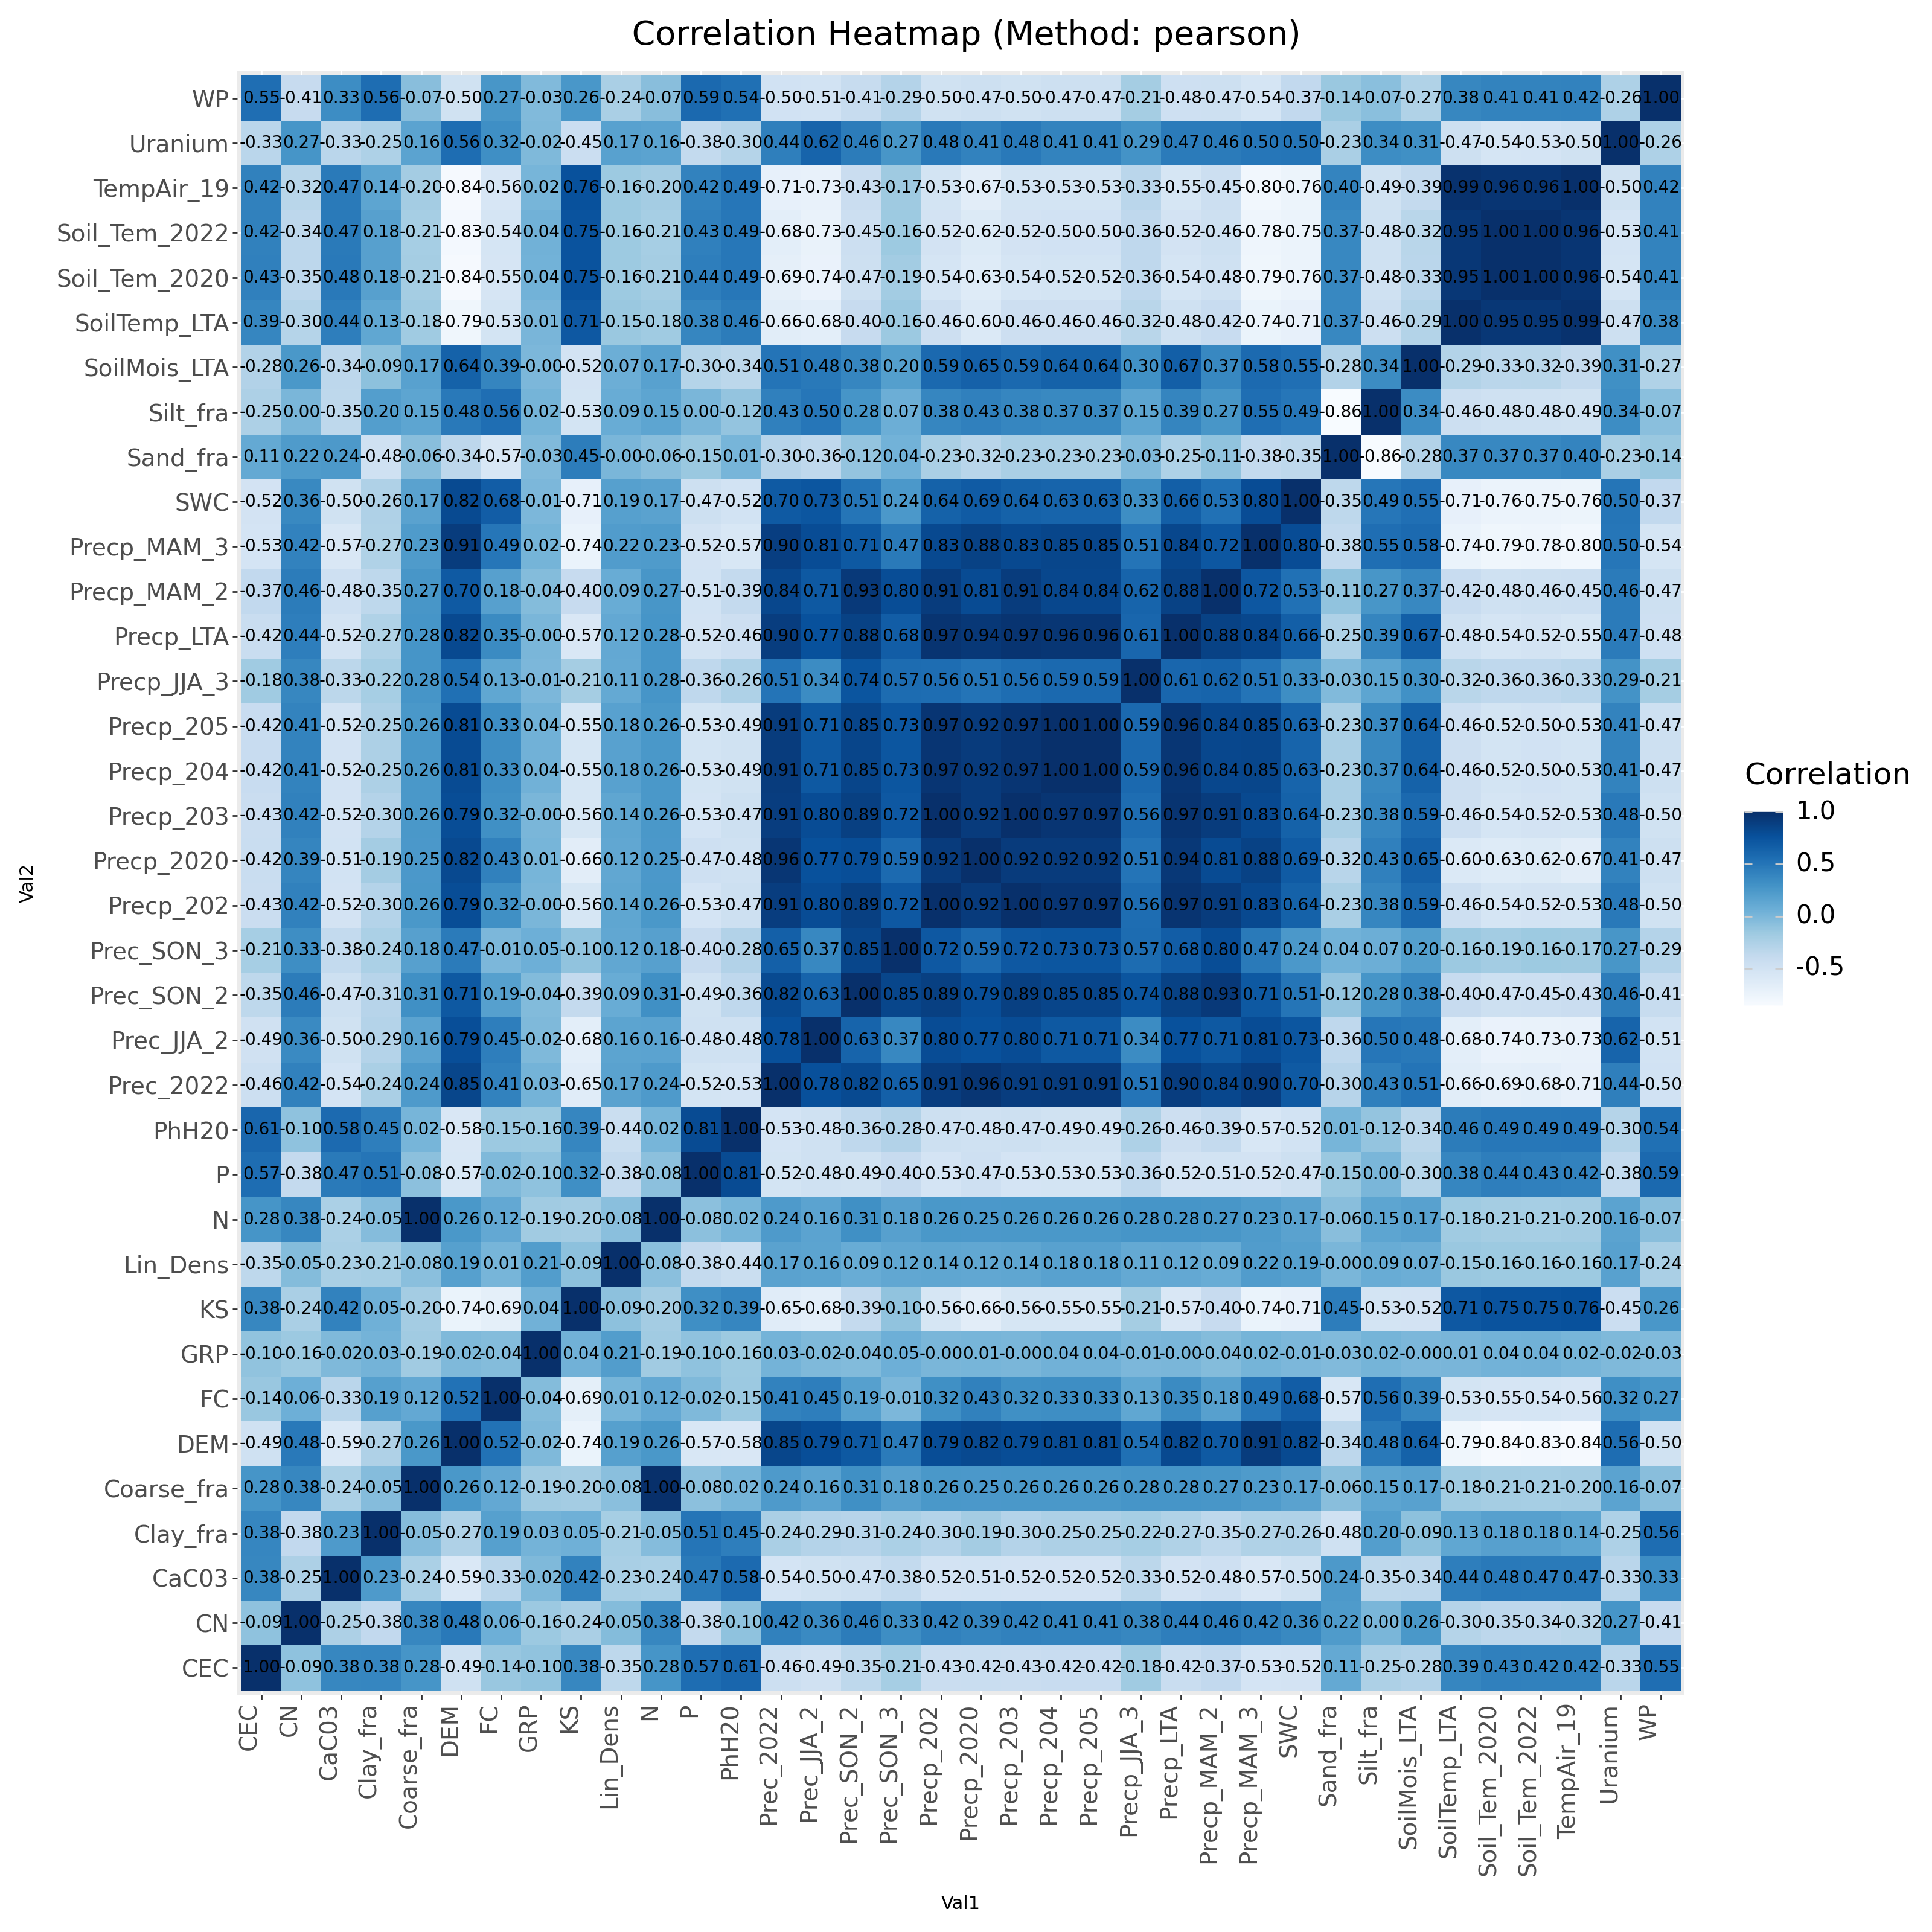

In [34]:
df_corr = Final_sample.drop(df_corr_columns_to_drop, axis=1)
df_corr_renamed = df_corr.rename(columns=rename_preds_dict)

import pandas as pd
from plotnine import ggplot, aes, geom_tile, geom_text, labs, theme, element_text, scale_fill_cmap

def make_and_plot_half_correlation_heatmap(
    data_frame: pd.DataFrame,
    method: str = 'pearson',
    figsize: tuple = (15, 15)
) -> ggplot:
    """
    Computes the correlation matrix for specified columns, renames columns, and returns a half-heatmap plot.
    """

    # Compute correlation matrix
    data_corr = data_frame.corr(method=method)

    # Convert to long format
    data_corr_long = data_corr.stack().reset_index()
    data_corr_long.columns = ["Val1", "Val2", "Correlation"]

    # Keep only the bottom-right triangle (excluding the diagonal)
    #data_corr_long = data_corr_long[data_corr_long["Val1"] < data_corr_long["Val2"]]

    # Create the heatmap plot
    heatmap = (
        ggplot(data_corr_long) +
        geom_tile(aes(x="Val1", y="Val2", fill="Correlation")) +
        geom_text(aes(x="Val1", y="Val2", label="Correlation"), format_string='{:.2f}', size=10) +
        labs(title=f" Correlation Heatmap (Method: {method})") +
        theme(
            figure_size=figsize,
            plot_title=element_text(hjust=0.5, size=20),
            axis_text_x=element_text(angle=90, hjust=1, size=14),
            axis_text_y=element_text(size=14),
            legend_title=element_text(size=18),
            legend_text=element_text(size=15)
        ) +
        scale_fill_cmap(cmap_name="Blues")
    )

    return heatmap
make_and_plot_half_correlation_heatmap(
   df_corr_renamed,
   'pearson',
    figsize = (16, 16)
)

In [35]:
feature_names=tuple(X.columns)
X.shape, y.shape
group_column='grids_36k'
target_column='GRP'

def feature_groups(dataframe):
    """
    Create a list of feature groups for the given DataFrame, where some features are grouped together.
    """
    filtered_dataframe = dataframe.drop(columns=['GRP', 'grids_36k'], axis=1)
    ungrouped_features = filtered_dataframe.drop(columns=feature_groups_list, axis=1)
    ungrouped_features_list = [
        [filtered_dataframe.columns.get_loc(col)] for col in ungrouped_features]

    grouped_features_tuple = [
        filtered_dataframe.columns.get_loc(col) for col in feature_groups_list
    ]
    grouped_features_list = [grouped_features_tuple]

    # Combine ungrouped and grouped features
    feature_group_all = ungrouped_features_list + grouped_features_list

    return feature_group_all

feature_group = feature_groups(Final_sample)
feature_group_seasonal = feature_groups(Final_sample_nonseasonal)

def aggregate_feature_importance(importance_df, feature_groups_list):
    """
    Grouped feature importance to sum the Geology features
    """
    # Aggregate grouped feature importance
    fimp_index = importance_df.set_index('Feature')
    aggregated_values = fimp_index.loc[feature_groups_list].sum()
    new_row = pd.DataFrame({
        'Feature': 'Geology',
        'Model Importance': [aggregated_values['Model Importance']],
        'Permutation Importance': [aggregated_values['Permutation Importance']]})

    importance_df = pd.concat([importance_df[~importance_df['Feature'].isin(
        feature_groups_list)], new_row], ignore_index=True)
    return importance_df.sort_values(by='Model Importance',
                                     ascending=False).reset_index(
                                         drop=True)


## Sequential Feature selection

In [36]:
def SFS_Algorithm_groups(data, target_column, group_column, base_estimator):
    """
    Perform Sequential Feature Selection (SFS) using grouped features.

    :param data: DataFrame containing features and target.
    :param target_column: Name of the target column.
    :param group_column: Name of the group column.
    :param base_estimator: Estimator to use in the sequential feature selection.
    :return: Tuple containing the plot figure, selected feature names, and metrics DataFrame.
    """
    # Prepare the data
    X = data.drop(columns=[target_column, group_column])
    y = data[target_column]
    groups = data[group_column]

    # Get feature groups
    feat_groups = feature_groups(data)

    # Initialize and fit the SFS model
    sfs = SFS(
        base_estimator,
        k_features=(10),
        forward=True,
        floating=False,
        feature_groups=feat_groups,
        scoring='r2',
        verbose=10,
        cv=loo
    )
    sfs = sfs.fit(X, y, groups=groups)

    # Plot the results
    fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
    plt.title(f'SFS {base_estimator.__class__.__name__} (w. StdErr)')
    plt.grid()
    plt.show()

    # Extract selected features and metrics
    selected_features = sfs.k_feature_names_
    sfs_metrics = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

    return fig, selected_features, sfs_metrics

In [37]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.inspection import permutation_importance
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd

def SFS_Algorithm_with_GridSearch(data, target_column, group_column, base_estimator, param_grid, max_features=35):
    """
    Perform Sequential Feature Selection (SFS) with GridSearchCV using grouped features and calculate feature importances.

    :param data: DataFrame containing features and target.
    :param target_column: Name of the target column.
    :param group_column: Name of the group column.
    :param base_estimator: Estimator to use in the sequential feature selection.
    :param param_grid: Dictionary of hyperparameters for grid search.
    :param max_features: Maximum number of features to select.
    :return: Tuple containing the plot figure, selected feature names, metrics DataFrame, and feature importances.
    """
    # Prepare the data
    X = data.drop(columns=[target_column, group_column])
    y = data[target_column]
    groups = data[group_column]

    # Get feature groups
    feat_groups = feature_groups(data)  # Assume feature_groups function is defined to group features

    # Define Leave-One-Group-Out (LOO) cross-validator
    loo = LeaveOneGroupOut()

    # GridSearchCV for the base estimator
    grid_search = GridSearchCV(base_estimator, param_grid, scoring='r2', cv=loo, verbose=1, n_jobs=-1)
    grid_search.fit(X, y, groups=groups)
    best_estimator = grid_search.best_estimator_

    # Initialize and fit the SFS model with the best estimator
    sfs = SFS(
        best_estimator,
        k_features=max_features,
        forward=True,
        floating=False,
        scoring='r2',
        feature_groups=feat_groups,
        cv=loo,
        verbose=10,
    )

    sfs = sfs.fit(X, y, groups=groups)

    # Plot the results
    fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
    plt.title(f'SFS {best_estimator.__class__.__name__} (w. StdErr)')
    plt.grid()
    plt.show()

    # Extract selected features and metrics
    selected_features = sfs.k_feature_names_
    sfs_metrics = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

    # Train the best estimator on the selected features to get feature importance
    X_selected = X.loc[:, selected_features]
    best_estimator.fit(X_selected, y)


    if hasattr(best_estimator, 'feature_importances_'):
        # Use feature_importances_ for models with this attribute
        feature_importances_ = pd.DataFrame({
            'Feature': selected_features,
            'Importance': best_estimator.feature_importances_
        }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

        feature_importances = aggregate_feature_importance(feature_importances, feature_groups_list)
    else:
        # Use permutation importance for models without feature_importances_
        perm_importance = permutation_importance(best_estimator, X_selected, y, n_repeats=10, random_state=0)
        feature_importances_ = pd.DataFrame({
            'Feature': selected_features,
            'Importance': perm_importance.importances_mean
        }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

        feature_importances = aggregate_feature_importance(feature_importances_, feature_groups_list)

    return fig, selected_features, sfs_metrics, feature_importances, best_estimator


In [47]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.inspection import permutation_importance
from sklearn.model_selection import LeaveOneGroupOut, GridSearchCV
import matplotlib.pyplot as plt
import pandas as pd

def aggregate_feature_importance(importance_df, feature_groups_list):
    """
    Aggregate grouped feature importance values.

    :param importance_df: DataFrame containing feature importance values.
    :param feature_groups_list: List of features to aggregate.
    :return: DataFrame with aggregated importance values.
    """
    # Set index to 'Feature' for easy aggregation
    fimp_index = importance_df.set_index('Feature')
    # Sum the importance values for the specified group of features
    aggregated_values = fimp_index.loc[feature_groups_list].sum()

    # Create new row for aggregated values
    new_row = pd.DataFrame({
        'Feature': ['Geology'],
        'Importance': [aggregated_values['Importance']],
        'Permutation Importance': [aggregated_values.get('Permutation Importance', None)]
    })

    # Filter out the grouped features and append the new aggregated row
    importance_df = pd.concat([importance_df[~importance_df['Feature'].isin(feature_groups_list)], new_row], ignore_index=True)
    return importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

def SFS_Algorithm_with_GridSearch(data, target_column, group_column, base_estimator, param_grid, feature_groups_list, max_features=35):
    """
    Perform Sequential Feature Selection (SFS) with GridSearchCV using grouped features and calculate feature importances.

    :param data: DataFrame containing features and target.
    :param target_column: Name of the target column.
    :param group_column: Name of the group column.
    :param base_estimator: Estimator to use in the sequential feature selection.
    :param param_grid: Dictionary of hyperparameters for grid search.
    :param feature_groups_list: List of features to aggregate in feature importance.
    :param max_features: Maximum number of features to select.
    :return: Tuple containing the plot figure, selected feature names, metrics DataFrame, feature importances, and best estimator.
    """
    # Prepare the data
    X = data.drop(columns=[target_column, group_column])
    y = data[target_column]
    groups = data[group_column]

    # Define Leave-One-Group-Out (LOO) cross-validator
    loo = LeaveOneGroupOut()
    feat_groups = feature_groups(data)  # Assume feature_groups function is defined to group features


    # Perform GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(base_estimator, param_grid, scoring='r2', cv=loo, verbose=1, n_jobs=-1)
    grid_search.fit(X, y, groups=groups)
    best_estimator = grid_search.best_estimator_

    # Initialize and fit the SFS model with the best estimator
    sfs = SFS(
        best_estimator,
        k_features=max_features,
        forward=True,
        floating=False,
        scoring='r2',
        cv=loo,
        feature_groups=feat_groups,
        verbose=40,
    )

    sfs = sfs.fit(X, y, groups=groups)

    # Plot the Sequential Feature Selector results
    fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')
    plt.title(f'SFS {best_estimator.__class__.__name__} (w. StdErr)')
    plt.grid()
    plt.show()

    # Extract selected features and metrics
    selected_features = sfs.k_feature_names_
    sfs_metrics = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

    # Train the best estimator on the selected features to get feature importance
    X_selected = X.loc[:, selected_features]
    best_estimator.fit(X_selected, y)

    # Obtain feature importance
    if hasattr(best_estimator, 'feature_importances_'):
        # Use feature_importances_ for models with this attribute
        feature_importances = pd.DataFrame({
            'Feature': selected_features,
            'Importance': best_estimator.feature_importances_
        }).sort_values(by='Importance', ascending=False).reset_index(drop=True)
    else:
        # Use permutation importance for models without feature_importances_
        perm_importance = permutation_importance(best_estimator, X_selected, y, n_repeats=10, random_state=0)
        feature_importances = pd.DataFrame({
            'Feature': selected_features,
            'Importance': perm_importance.importances_mean
        }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    # Aggregate feature importance for specified groups
    feature_importances = aggregate_feature_importance(feature_importances, feature_groups_list)

    return fig, selected_features, sfs_metrics, feature_importances, best_estimator


# RF

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    8.4s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:   10.2s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:   11.9s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:   13.4s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:   15.2s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:   16.6s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:   17.4s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:   18.5s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:   19.8s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:   20.9s
[Parallel(n_jobs=1)]: Do

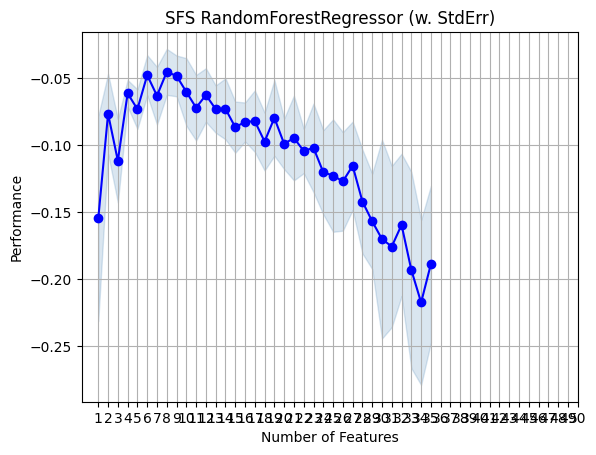

In [39]:
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [None, 10, 20],
    'oob_score':[True,False],
}
fig_rf, selected_features_rf, sfs_metrics_rf, feature_importances_rf, best_estimator_rf = SFS_Algorithm_with_GridSearch(
    Final_sample,
    target_column=target_column,
    group_column=group_column,
    base_estimator=RandomForestRegressor(),
    param_grid=param_grid,
    feature_groups_list=feature_groups_list
)


In [40]:
sfs_metrics_rf

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(21,)","[-0.06028238995066748, -0.44520720540925884, -...",-0.154898,"(Precp_MAM_2,)",0.196729,0.153062,0.076531
2,"(12, 21)","[0.0034594728867218816, -0.15835247930233343, ...",-0.076737,"(Lin_Dens, Precp_MAM_2)",0.07681,0.059761,0.02988
3,"(10, 12, 21)","[-0.06443221823800638, -0.08966564197523641, -...",-0.111765,"(SWC, Lin_Dens, Precp_MAM_2)",0.080065,0.062293,0.031147
4,"(10, 12, 17, 21)","[-0.03701780481139849, -0.0372593240187411, -0...",-0.061467,"(SWC, Lin_Dens, Precp_2020, Precp_MAM_2)",0.025782,0.020059,0.01003
5,"(8, 10, 12, 17, 21)","[-0.11636559619398756, -0.06453818850784243, -...",-0.073256,"(FC, SWC, Lin_Dens, Precp_2020, Precp_MAM_2)",0.037943,0.029521,0.01476
6,"(8, 9, 10, 12, 17, 21)","[-0.07382699515445768, -0.024478548160287827, ...",-0.047875,"(FC, KS, SWC, Lin_Dens, Precp_2020, Precp_MAM_2)",0.038434,0.029903,0.014952
7,"(8, 9, 10, 12, 17, 18, 21)","[-0.07658899032178956, -0.07734177565278633, -...",-0.063228,"(FC, KS, SWC, Lin_Dens, Precp_2020, Prec_2022,...",0.055255,0.04299,0.021495
8,"(3, 8, 9, 10, 12, 17, 18, 21)","[-0.060754197859004044, -0.06038370750853983, ...",-0.045445,"(CN, FC, KS, SWC, Lin_Dens, Precp_2020, Prec_2...",0.044139,0.034342,0.017171
9,"(3, 6, 8, 9, 10, 12, 17, 18, 21)","[-0.05685739525349809, -0.06707844667801499, -...",-0.048411,"(CN, PhH20, FC, KS, SWC, Lin_Dens, Precp_2020,...",0.039126,0.030441,0.01522
10,"(3, 6, 8, 9, 10, 12, 17, 18, 21, 25)","[-0.08685946249573107, -0.021314259445831762, ...",-0.06037,"(CN, PhH20, FC, KS, SWC, Lin_Dens, Precp_2020,...",0.064778,0.050399,0.0252


In [44]:
#aggregate_feature_importance(feature_importances_rf, feature_groups_list)

RFI = {'Feature':['WP','Geol','PhH20','FC','N',
                  'DEM','Lin_Densit','CEC','Sand_fra','Silt_fra'],
       'Importance':[0.174,0.122,0.121,0.117,0.092,0.091,
                     0.089,0.068,0.062,0.062]}
print(pd.DataFrame(RFI))

feature_importances_rf

      Feature  Importance
0          WP       0.174
1        Geol       0.122
2       PhH20       0.121
3          FC       0.117
4           N       0.092
5         DEM       0.091
6  Lin_Densit       0.089
7         CEC       0.068
8    Sand_fra       0.062
9    Silt_fra       0.062


,Feature,Importance,Permutation Importance
0,Prec_SON_2,0.222086,NaN
1,KS,0.091071,NaN
2,Lin_Dens,0.068681,NaN
3,DEM,0.060912,NaN
4,Geology,0.044446,None
5,Precp_204,0.041880,NaN
6,Precp_205,0.039702,NaN
7,SoilTemp_LTA,0.035456,NaN
8,Prec_SON_3,0.027319,NaN
9,TempAir_19,0.025039,NaN


In [45]:
best_estimator_rf

RandomForestRegressor(max_depth=10)

# SVR

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    4.7s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    5.5s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    5.8s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    6.2s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    7.0s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Do

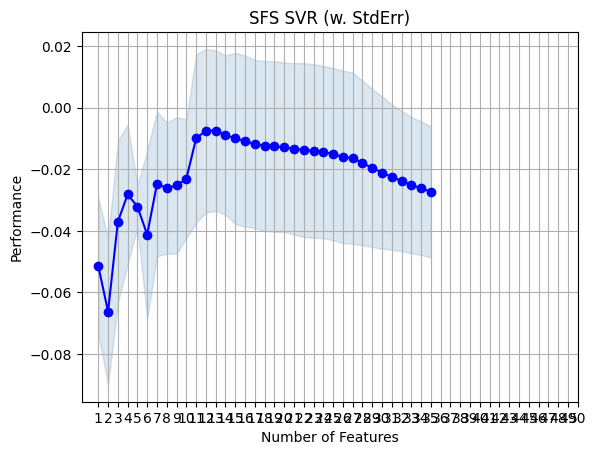

In [46]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Initialize SVR model
svr_grid = SVR(kernel='rbf')

# Reduced parameter grid for faster search
param_svr = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.001, 0.01, 0.1, 1],
    'gamma': [0.001, 0.01, 0.1, 1]
}


fig_svr, selected_features_svr, sfs_metrics_svr, feature_importances_svr, best_estimator_svr = SFS_Algorithm_with_GridSearch(
    Final_sample,
    target_column=target_column,
    group_column=group_column,
    base_estimator=svr_grid,
    param_grid=param_svr,
    feature_groups_list=feature_groups_list
)


In [49]:
sfs_metrics_svr

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(20,)","[-0.014885874924787768, -0.0403295221712443, -...",-0.051429,"(Precp_JJA_3,)",0.056955,0.044313,0.022156
2,"(15, 20)","[-0.03544509061524104, -0.13922870674525667, -...",-0.066215,"(Sand_fra, Precp_JJA_3)",0.06117,0.047592,0.023796
3,"(4, 15, 20)","[-0.05053233519196332, -0.08715705992002865, -...",-0.03708,"(N, Sand_fra, Precp_JJA_3)",0.067518,0.052531,0.026265
4,"(4, 14, 15, 20)","[-0.008951358190128378, -0.07608961322135532, ...",-0.028205,"(N, Coarse_fra, Sand_fra, Precp_JJA_3)",0.058159,0.04525,0.022625
5,"(4, 14, 15, 20, 34)","[-0.047880976617999726, -0.037816497929380244,...",-0.032124,"(N, Coarse_fra, Sand_fra, Precp_JJA_3, Uranium)",0.017771,0.013827,0.006913
6,"(4, 14, 15, 20, 24, 34)","[-0.07012554260778714, -0.04638601127679687, -...",-0.041247,"(N, Coarse_fra, Sand_fra, Precp_JJA_3, Prec_SO...",0.070083,0.054527,0.027263
7,"(4, 14, 15, 20, 21, 24, 34)","[-0.058577712693962614, 0.027598424017219347, ...",-0.024765,"(N, Coarse_fra, Sand_fra, Precp_JJA_3, Precp_M...",0.060542,0.047104,0.023552
8,"(4, 14, 15, 20, 21, 24, 27, 34)","[-0.04604902112051734, -0.027248366369430288, ...",-0.026145,"(N, Coarse_fra, Sand_fra, Precp_JJA_3, Precp_M...",0.054576,0.042462,0.021231
9,"(4, 14, 15, 16, 20, 21, 24, 27, 34)","[-0.0462347497343738, -0.0006031304327878129, ...",-0.025297,"(N, Coarse_fra, Sand_fra, Silt_fra, Precp_JJA_...",0.056959,0.044316,0.022158
10,"(1, 4, 14, 15, 16, 20, 21, 24, 27, 34)","[-0.0169995700599872, 0.0029715416752387203, -...",-0.023111,"(CaC03, N, Coarse_fra, Sand_fra, Silt_fra, Pre...",0.049526,0.038533,0.019266


In [52]:
SVRI = {'Feature':['Geol', 'Coarse_p','N','WP','CaC03',
                  'Lin_Densit','P','Clay_fra','Precip_LTA','CN'],
       'Importance':[ 40.741, 29.289,29.289,7.445,4.822,
                     3.343,3.093,2.191,1.863,1.668]}
print(pd.DataFrame(SVRI))


#print(feature_importances_svr)

      Feature  Importance
0        Geol      40.741
1    Coarse_p      29.289
2           N      29.289
3          WP       7.445
4       CaC03       4.822
5  Lin_Densit       3.343
6           P       3.093
7    Clay_fra       2.191
8  Precip_LTA       1.863
9          CN       1.668


In [53]:
best_estimator_svr

SVR(C=1, gamma=1)

# GBR

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done   6 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done   7 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done   8 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done   9 tasks      | elapsed:    5.7s
[Parallel(n_jobs=1)]: Done  10 tasks      | elapsed:    6.2s
[Parallel(n_jobs=1)]: Done  11 tasks      | elapsed:    6.8s
[Parallel(n_jobs=1)]: Done  12 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done  13 tasks      | elapsed:    7.8s
[Parallel(n_jobs=1)]: Done  14 tasks      | elapsed:    8.5s
[Parallel(n_jobs=1)]: Done  15 tasks      | elapsed:    9.2s
[Parallel(n_jobs=1)]: Done  16 tasks      | elapsed:   10.0s
[Parallel(n_jobs=1)]: Do

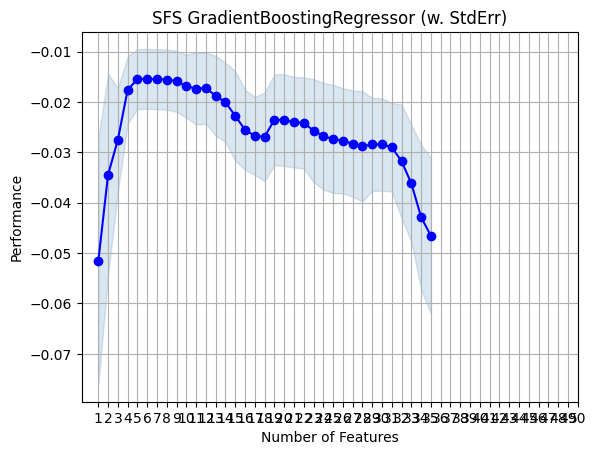

In [54]:
# Define the parameter grid for GradientBoostingRegressor

from sklearn.ensemble import GradientBoostingRegressor # Import the GradientBoostingRegressor class

#gbr_sfs = GradientBoostingRegressor(n_estimators=100, max_depth=None, learning_rate=0.1) # Now you can use it

param_grid_gbr = {
    'n_estimators':[100, 200, 300,500,1000],
    'learning_rate': [0.0001, 0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7,10],
}

# Initialize GradientBoostingRegressor and GridSearchCV
gbr = GradientBoostingRegressor(random_state=42)

fig_gbr, selected_features_gbr, sfs_metrics_gbr, feature_importances_gbr, best_estimator_gbr = SFS_Algorithm_with_GridSearch(
    Final_sample,
    target_column=target_column,
    group_column=group_column,
    base_estimator=gbr,
    param_grid=param_grid_gbr,
    feature_groups_list=feature_groups_list
)


In [56]:
sfs_metrics_gbr

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(23,)","[0.027821738599851487, -0.07161303923521545, -...",-0.051632,"(Prec_SON_2,)",0.063066,0.049068,0.024534
2,"(23, 27)","[0.012700959471426576, -0.05180509182577131, -...",-0.034427,"(Prec_SON_2, Precp_204)",0.051476,0.04005,0.020025
3,"(12, 23, 27)","[0.00010672729104488354, -0.045517085678855596...",-0.0275,"(Lin_Dens, Prec_SON_2, Precp_204)",0.026457,0.020584,0.010292
4,"(3, 12, 23, 27)","[0.006516151240093304, -0.03205592508464572, -...",-0.017591,"(CN, Lin_Dens, Prec_SON_2, Precp_204)",0.017083,0.013291,0.006645
5,"(3, 6, 12, 23, 27)","[0.008032599956859343, -0.025156968752464204, ...",-0.015441,"(CN, PhH20, Lin_Dens, Prec_SON_2, Precp_204)",0.015308,0.01191,0.005955
6,"(3, 6, 12, 23, 27, 28)","[0.008032599956859343, -0.025156968752464204, ...",-0.015403,"(CN, PhH20, Lin_Dens, Prec_SON_2, Precp_204, P...",0.015286,0.011893,0.005947
7,"(3, 6, 12, 21, 23, 27, 28)","[0.008000846290407537, -0.02507737510594632, -...",-0.015468,"(CN, PhH20, Lin_Dens, Precp_MAM_2, Prec_SON_2,...",0.015291,0.011897,0.005949
8,"(3, 6, 12, 18, 21, 23, 27, 28)","[0.008030044574149797, -0.025055316362449398, ...",-0.015533,"(CN, PhH20, Lin_Dens, Prec_2022, Precp_MAM_2, ...",0.015361,0.011951,0.005976
9,"(3, 6, 12, 17, 18, 21, 23, 27, 28)","[0.007946462780859531, -0.025997036748894864, ...",-0.015872,"(CN, PhH20, Lin_Dens, Precp_2020, Prec_2022, P...",0.015598,0.012136,0.006068
10,"(3, 6, 12, 17, 18, 21, 22, 23, 27, 28)","[0.007946462780859531, -0.025997036748894864, ...",-0.016862,"(CN, PhH20, Lin_Dens, Precp_2020, Prec_2022, P...",0.016065,0.012499,0.00625


In [58]:
GBMI = {'Feature':['Geol','Coarse_p','N','CaC03','WP',
                   'Clay_fra','CN','P','FC','Sand_fra'],
        'Importance':[47.408, 13.10, 12.90, 12.85, 9.30,
                      7.91, 3.73, 2.81, 2.67, 2.44]}
print(pd.DataFrame(GBMI))
feature_importances_gbr

    Feature  Importance
0      Geol      47.408
1  Coarse_p      13.100
2         N      12.900
3     CaC03      12.850
4        WP       9.300
5  Clay_fra       7.910
6        CN       3.730
7         P       2.810
8        FC       2.670
9  Sand_fra       2.440


,Feature,Importance,Permutation Importance
0,Prec_SON_2,0.487176,NaN
1,KS,0.138113,NaN
2,Precp_205,0.116197,NaN
3,Precp_204,0.095226,NaN
4,DEM,0.046214,NaN
5,FC,0.025399,NaN
6,Lin_Dens,0.018866,NaN
7,TempAir_19,0.012847,NaN
8,N,0.012406,NaN
9,Geology,0.010945,None


In [59]:
best_estimator_gbr

GradientBoostingRegressor(learning_rate=0.01, random_state=42)

# Post Hyperparameter tuning

In [ ]:
RF_sfs = RandomForestRegressor(n_estimators=500,max_depth=None, oob_score=True, random_state=24)


In [67]:
_X = X.drop(columns= [group_column], axis=1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

# Example Data (replace with your dataset)
#from sklearn.datasets import make_regression

#X, y = make_regression(n_samples=1000, n_features=10, noise=0.1, random_state=42)

# Define hyperparameter grids
param_grid_rf = {'n_estimators': [100, 500, 1000],'max_depth': [None, 10, 20],
                 'oob_score': [True, False]}

param_grid_svr = { 'model__C': [0.1, 1, 10],'model__epsilon': [0.01, 0.1, 1],
                   'model__gamma': ['scale',0.0001, 0.1, 1]}

param_grid_gbrt = {'n_estimators': [100, 200, 1000], 'learning_rate': [0.01, 0.1],
                   'max_depth': [3, 5, 7]}


param_grid_mlpr = {'model__hidden_layer_sizes': [(50,), (100,), (50, 50, 50)],
                  'model__activation': ['relu', 'tanh'],
                  'model__solver': ['adam',],
                  'model__learning_rate': ['constant', 'adaptive'],
                  'model__max_iter': [200, 500, 100000], }

# Create models
models = {
    "RandomForest": (RandomForestRegressor(random_state=42), param_grid_rf),
    "SVR": (Pipeline([('scaler', StandardScaler()), ('model', SVR())]), param_grid_svr),
    "GBRT": (GradientBoostingRegressor(random_state=42), param_grid_gbrt),
    "MLPR": (Pipeline([('scaler', StandardScaler()), ('model', MLPRegressor(
        alpha=0.0001, random_state=42))]), param_grid_mlpr),}


# Define scoring metric
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# GridSearch for each model
best_models = {}
for model_name, (model, param_grid) in models.items():
    print(f"Running GridSearch for {model_name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scorer,
        cv=5,
        verbose=10,
        n_jobs=-1
    )
    grid_search.fit(_X, y)
    best_models[model_name] = {
        "Best Params": grid_search.best_params_,
        "Best Score": -grid_search.best_score_  # Convert negative MSE back to positive
    }

# Display results
for model_name, results in best_models.items():
    print(f"\n{model_name}:")
    print(f"Best Parameters: {results['Best Params']}")
    print(f"Best Score (MSE): {results['Best Score']:.4f}")


Running GridSearch for RandomForest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
